In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import popularity_metadata_options
import models_nn

importing Jupyter notebook from popularity_metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [3]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/popularity/mean_merge.csv')
df = df.dropna()

In [4]:
df.head()

,Unnamed: 0,full_text_x,Emotional_disclosure,Information_disclosure,score_x,emo_disc.1,emo_disc.2,emo_disc.3,emo_disc.4,info_disc.1,...,WorkTime.2_y,WorkTime.3_y,WorkTime.4_y,popularity_y,num_words,num_chars,emo_disc_pc_agree,info_disc_pc_agree,emo_supp_pc_agree,info_supp_pc_agree
0,0,'' Alot of people DONT think like that when t...,0,0,2,True,True,True,False,False,...,11,7,19,0,12,57,0.75,0.50,1.0,0.75
1,1,'Official' would be one way to describe it.,1,0,2,False,False,False,True,True,...,43,11,41,0,8,43,0.75,0.75,1.0,1.00
2,2,"""...you mix me a cocktail.""",0,0,2,True,True,True,False,False,...,47,10,4,0,5,27,0.75,0.50,1.0,0.75
3,3,"""Be kind, for everyone you meet is fighting a ...",0,0,3,True,True,True,False,True,...,10,7,13,0,14,77,0.75,1.00,1.0,1.00
4,4,"""Consider yourself lucky because I chose you""?",0,0,1,True,True,True,True,True,...,9,66,23,0,7,46,1.00,1.00,1.0,1.00


In [5]:
###################################
# pipeline-onehot Function blocks #
###################################

def sss_train_test_split(dataframe, class_name, n_splits, test_size, random_state):
    y = dataframe[class_name].copy()
    X = dataframe.drop([class_name], axis=1)
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    splits_generator = sss.split(X, y)

    for train_idx, test_idx in splits_generator:
        indices_train = train_idx
        indices_test = test_idx

    train = df.take(indices_train)
    test = df.take(indices_test)
    
    return indices_train, indices_test, train, test

def generate_class_weights(train_data, class_name, annotation_name):
    y_train = train_data[annotation_name].to_numpy()
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    return y_train, class_weight_dict

def label_preprocessing(y_data, label_encoder):
    out = label_encoder.fit_transform(y_data).reshape(-1,1)
    return out

def individual_model(annot_name, x_train_data, y_train_data, x_val_data, y_val_data, class_weight_dict, indiv_batch_size, indiv_epochs):
    model = models_nn.create_nn_model()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(),
                  metrics = ['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
    history = model.fit(x_train_data,y_train_data,
                        batch_size=indiv_batch_size,
                        epochs=indiv_epochs,
                        validation_data=(x_val_data, y_val_data), 
#                         callbacks=[models_nn.early_stop],
                        class_weight=class_weight_dict,
                        verbose=0)
    
    pred = model.predict(x_train_data)
    pred_test = model.predict(x_val_data)

    pred_test_round = pred_test.round()
    
    validation_metrics_dict = history.history
    val_f1_list = history.history['val_f1_m']
    best_val_f1 = max(val_f1_list)
    best_val_prec = history.history['val_precision_m'][val_f1_list.index(best_val_f1)]
    best_val_recall = history.history['val_recall_m'][val_f1_list.index(best_val_f1)]
    macro_scores = precision_recall_fscore_support(y_val_data, pred_test_round, average='macro')
    print("#############################################################")
    print("Metrics for {} individual model:".format(annot_name))
    print("Best validation metrics: F1 = {}, Precision = {}, Recall = {}".format(best_val_f1,
                                                                                 best_val_prec,
                                                                                 best_val_recall))
    print("Macro validation metrics: F1 = {}, Precision = {}, Recall = {}".format(macro_scores[2],
                                                                                  macro_scores[0],
                                                                                  macro_scores[1]))
    return pred, pred_test

# (HARD-CODED)
def generate_encodings(info_support_pred, emo_support_pred, info_disclosure_pred, emo_disclosure_pred):
    pred_df_arr_full = []

    for i in range(0, len(info_support_pred)):
        pred_obj_1 = {}
        pred_obj_1['info_support'] = info_support_pred[i][0]
        pred_obj_1['emo_support'] = emo_support_pred[i][0]
        pred_obj_1['info_disclosure'] = info_disclosure_pred[i][0]
        pred_obj_1['emo_disclosure'] = emo_disclosure_pred[i][0]
        pred_df_arr_full.append(pred_obj_1)

    pred_df_full = pd.DataFrame(pred_df_arr_full)
    return pred_df_full

def joint_model(weights_name, pred_df_full, y_train_1, pred_df_full_test, y_test_1,
                class_weight_dict_1, joint_batch_size, joint_epochs):
    
    def helper(predict_name, pred_df, y_train, pred_df_test, y_test, class_weight_dict, joint_batch_size, 
               joint_epochs):
        joint_full_model = models_nn.create_joint_model(pred_df)
        history = joint_full_model.fit(x=pred_df, 
                                           y=y_train, 
                                           epochs=joint_epochs, 
                                           batch_size=joint_batch_size, 
                                           validation_data=(pred_df_test, y_test), 
#                                            callbacks=[models_nn.callback], 
                                           class_weight=class_weight_dict,
                                           verbose=0)
        joint_predict = joint_full_model.predict(pred_df_test)
#         joint_predict_round = []
#         for a in joint_predict:
#             joint_predict_round.append(np.argmax(a))
        joint_predict_round = joint_predict.round()
        out1 = precision_recall_fscore_support(y_test, np.array(joint_predict_round), average='macro')

        val_f1_list = history.history['val_f1_m']
        best_val_f1 = val_f1_list[-1]
        best_val_prec = history.history['val_precision_m'][val_f1_list.index(best_val_f1)]
        best_val_recall = history.history['val_recall_m'][val_f1_list.index(best_val_f1)]
        macro_scores = out1
        if weights_name == None:
            print("Metrics for {} joint model w/o weights:".format(predict_name))
        else:
            print("Metrics for {} joint model weighted by {}".format(predict_name, weights_name))
        print("Best validation metrics: F1 = {}, Precision = {}, Recall = {}".format(best_val_f1,
                                                                                     best_val_prec,
                                                                                     best_val_recall))
        print("Macro validation metrics: F1 = {}, Precision = {}, Recall = {}".format(macro_scores[2],
                                                                                      macro_scores[0],
                                                                                      macro_scores[1]))
        return [best_val_f1, best_val_prec, best_val_recall], macro_scores
    
    print("#############################################################")
    decep_1, decep_2 = helper("Popularity", pred_df_full, y_train_1, pred_df_full_test, y_test_1, class_weight_dict_1, joint_batch_size, joint_epochs)
    
    return decep_1, decep_2

In [6]:
##################################################
# Main function for dataset sampling experiments #
##################################################

# Currently only supports annotations with 2 classes, i.e. binary

def dataset_sampling(dataframe, class_name, sampling_size_list, metadata_options_list, model_name):
    
    # Misc variables
    results = {}
    
    # Model settings (for individual annotation models)
    models_nn.MODEL_NAME = model_name
    
    # Full dataframe proportions
    full_size = dataframe.shape[0]
    full_counts = dataframe[class_name].value_counts()
    print("Full dataset proportions w.r.t. {}".format(class_name))
    print(full_counts)
    full_counts_dict = full_counts.to_dict()
    full_counts_list = list(full_counts_dict.values())
    
    ## class_proportions is a list of class proportions, first item corresponding to first class, etc
    class_proportions = []
    for each_class_counts in full_counts_list:
        class_proportions.append(each_class_counts / full_size)

    # Looping through sample_size_list
    for each_sample_size in sampling_size_list:
        
        print("#################################")
        print("Sample size: {}".format(each_sample_size))
        print("#################################")
        
        ## Counting number of datapoints per class proportionate to main dataset
        class_sizes = [round(each_sample_size * class_proportions[0])]
        class_sizes.append(each_sample_size - class_sizes[0])

        ## Creating sub dataframe
        s0 = dataframe.loc[dataframe[class_name] == list(full_counts_dict.keys())[0]].sample(class_sizes[0]).index
        s1 = dataframe.loc[dataframe[class_name] == list(full_counts_dict.keys())[1]].sample(class_sizes[1]).index
        sub_df = dataframe.loc[s0.union(s1)]

        # Metadata settings
        print("#############################################################")
        print("Metadata options for current sample")
        df_throughput, df_worktime, df_agreement, df_textlength, df_special = popularity_metadata_options.set_OHE_pipeline_options(sub_df, *metadata_options_list)
  
        ## Train_test_split using SSS
        indices_train, indices_test, train, test = sss_train_test_split(sub_df, class_name, n_splits, test_size, random_state)
        
        ## Generate class weights dict and y_train data (HARD-CODED)
        y_train_popularity, popularity_class_weight_dict = generate_class_weights(train, class_name, "popularity_x")
        y_train_emo_disclosure, emo_disclosure_class_weight_dict = generate_class_weights(train, class_name, 'Emotional_disclosure')
        y_train_info_disclosure, info_disclosure_class_weight_dict = generate_class_weights(train, class_name, 'Information_disclosure')
        y_train_emo_support, emo_support_class_weight_dict = generate_class_weights(train, class_name, 'Emo_support')
        y_train_info_support, info_support_class_weight_dict = generate_class_weights(train, class_name, 'Info_support')
        print("#############################################################")
        print("Class weights generated")
        print("Popularity: {} \nEmo Disclosure: {} \nInfo Disclosure: {} \nEmo Support: {} \nInfo Support: {}".format(popularity_class_weight_dict,
                                                                                                          emo_disclosure_class_weight_dict,
                                                                                                          info_disclosure_class_weight_dict,
                                                                                                          emo_support_class_weight_dict,
                                                                                                          info_support_class_weight_dict))
        
        ## Train and test data preparation (HARD-CODED)
        X_train_col = train['full_text_x']
        
        y_test_popularity = test['popularity_x'].tolist()
        y_test_emo_disclosure = test['Emotional_disclosure'].tolist()
        y_test_info_disclosure = test['Information_disclosure'].tolist()
        y_test_emo_support = test['Emo_support'].tolist()
        y_test_info_support = test['Info_support'].tolist()

        X_test_col = test['full_text_x']
        
        # Label encodings
        le = LabelEncoder()

        y_train_popularity = train['popularity_x'].tolist()
        y_train_popularity = le.fit_transform(y_train_popularity)
        y_train_popularity = y_train_popularity.reshape(-1,1)

        y_train_emo_disclosure = train['Emotional_disclosure'].tolist()
        y_train_emo_disclosure = le.fit_transform(y_train_emo_disclosure)
        y_train_emo_disclosure = y_train_emo_disclosure.reshape(-1,1)

        y_train_info_disclosure = train['Information_disclosure'].tolist()
        y_train_info_disclosure = le.fit_transform(y_train_info_disclosure)
        y_train_info_disclosure = y_train_info_disclosure.reshape(-1,1)

        y_train_emo_support = train['Emo_support'].tolist()
        y_train_emo_support = le.fit_transform(y_train_emo_support)
        y_train_emo_support = y_train_emo_support.reshape(-1,1)

        y_train_info_support = train['Info_support'].tolist()
        y_train_info_support = le.fit_transform(y_train_info_support)
        y_train_info_support = y_train_info_support.reshape(-1,1)
        
        ## Tokenizer settings
        max_words = 1000
        max_len = 220

        tok = Tokenizer(num_words=max_words)

        tok.fit_on_texts(X_train_col)
        X_train_sequences = tok.texts_to_sequences(X_train_col)
        X_train = pad_sequences(X_train_sequences, maxlen=max_len)

        X_test_sequences = tok.texts_to_sequences(X_test_col)
        X_test = pad_sequences(X_test_sequences, maxlen=max_len)
        
        ## Individual Models (HARD-CODED)
        ### Deception pred and pred_test not needed
        y_train_popularity = np.asarray(y_train_popularity)
        y_test_popularity = np.asarray(y_test_popularity)
        y_train_emo_disclosure = np.asarray(y_train_emo_disclosure)
        y_test_emo_disclosure = np.asarray(y_test_emo_disclosure)
        y_train_info_disclosure = np.asarray(y_train_info_disclosure)
        y_test_info_disclosure = np.asarray(y_test_info_disclosure)
        y_train_emo_support = np.asarray(y_train_emo_support)
        y_test_emo_support = np.asarray(y_test_emo_support)
        y_train_info_support = np.asarray(y_train_info_support)
        y_test_info_support = np.asarray(y_test_info_support)
        _, _ = individual_model('Popularity', X_train, y_train_popularity, X_test, y_test_popularity, popularity_class_weight_dict, indiv_batch_size, indiv_epochs)
        emo_disclosure_pred, emo_disclosure_pred_test = individual_model('Emotional Disclosure', X_train, y_train_emo_disclosure, X_test, y_test_emo_disclosure, emo_disclosure_class_weight_dict, indiv_batch_size, indiv_epochs)
        info_disclosure_pred, info_disclosure_pred_test = individual_model('Information Disclosure', X_train, y_train_info_disclosure, X_test, y_test_info_disclosure, info_disclosure_class_weight_dict, indiv_batch_size, indiv_epochs)
        emo_support_pred, emo_support_pred_test = individual_model('Emotional Support', X_train, y_train_emo_support, X_test, y_test_emo_support, emo_support_class_weight_dict, indiv_batch_size, indiv_epochs)
        info_support_pred, info_support_pred_test = individual_model('Information Support', X_train, y_train_info_support, X_test, y_test_info_support, info_support_class_weight_dict, indiv_batch_size, indiv_epochs)
        
        ## Generate one-hot encodings (HARD-CODED)
        pred_df = generate_encodings(info_support_pred, emo_support_pred, info_disclosure_pred, emo_disclosure_pred)
        pred_test_df = generate_encodings(info_support_pred_test, emo_support_pred_test, info_disclosure_pred_test, emo_disclosure_pred_test)
        
        # Generate weighted one-hot encodings (HARD-CODED)
        pred_df_throughput, pred_df_worktime, pred_df_agreement, pred_df_textlength, pred_df_special = popularity_metadata_options.construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df)
        pred_df_throughput_test, pred_df_worktime_test, pred_df_agreement_test, pred_df_textlength_test, pred_df_special_test = popularity_metadata_options.construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df)
        print("#############################################################")
        print("Weighted one-hot encodings generated")
        
        ## Joint model w/o weights
        out1_wo_weights, _ = joint_model(None, pred_df, y_train_popularity, pred_test_df, y_test_popularity, 
                                                             popularity_class_weight_dict, joint_batch_size, joint_epochs)
        # Joint model weighted by Throughput
        out1_tp, _ = joint_model('Throughput', pred_df_throughput, y_train_popularity, pred_df_throughput_test, y_test_popularity,
                                                       popularity_class_weight_dict, joint_batch_size, joint_epochs)
        # Joint model weighted by Worktime
        out1_wt, _ = joint_model('Worktime', pred_df_worktime, y_train_popularity, pred_df_worktime_test, y_test_popularity,
                                                       popularity_class_weight_dict, joint_batch_size, joint_epochs)
        # Joint model weighted by PC Agreement
        out1_pc, _ = joint_model('PC Agreement', pred_df_agreement, y_train_popularity, pred_df_agreement_test, y_test_popularity,
                                                       popularity_class_weight_dict, joint_batch_size, joint_epochs)
        # Joint model weighted by Text Length
        out1_tl, _ = joint_model('Text Length', pred_df_textlength, y_train_popularity, pred_df_textlength_test, y_test_popularity,
                                                       popularity_class_weight_dict, joint_batch_size, joint_epochs)
        
        # Joint model weighted by Special options
        out1_sp, _ = joint_model('Special', pred_df_special, y_train_popularity, pred_df_special_test, y_test_popularity,
                                                       popularity_class_weight_dict, joint_batch_size, joint_epochs)
        
        results['run_' + str(each_sample_size)] = [out1_wo_weights, out1_tp, out1_wt, 
                                                   out1_pc, out1_tl, out1_sp]
#         results['run_' + str(each_sample_size)] = [out1_wo_weights]
    print("Done")
    return results

In [7]:
####################################
# Arguments for current experiment #
####################################

# Metadata options
throughput_option = 'TP2'
worktime_option = 'WT1'
pc_agreement_option = 'PC1'
textlength_option = 'TL2'
special_option = 'SP1'
k_option_for_tp = 3
metadata_options_choices = [throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp]

# Train_test_split SSS options
n_splits = 1
test_size = 0.2
random_state = 0

# Individual model options
model_name = 'cnn'
models_nn.MODEL_NAME = model_name
indiv_batch_size = 128
indiv_epochs = 15

# Joint model options
joint_batch_size = 64
joint_epochs = 32

Full dataset proportions w.r.t. popularity_x
0    14254
1     3219
Name: popularity_x, dtype: int64
#################################
Sample size: 17473
#################################
#############################################################
Metadata options for current sample
TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
#############################################################
Class weights generated
Popularity: {0: 0.6129088836271157, 1: 2.7141747572815533} 
Emo Disclosure: {0: 0.7872268528947961, 1

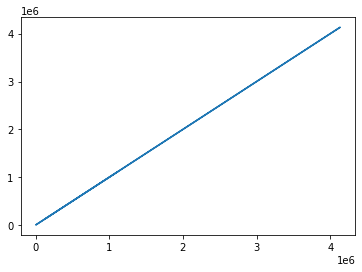

In [8]:
sampling_sizes = [17473]

results_dict = dataset_sampling(dataframe=df, 
                                class_name="popularity_x", 
                                sampling_size_list=sampling_sizes, 
                                metadata_options_list=metadata_options_choices, 
                                model_name=model_name)

In [9]:
# def translate_into_pandas(results_dictionary, metric_of_focus):
#     def helper(metric_of_focus_number):
#         new_dict = {}
#         for each_key, each_values_list in results_dictionary.items():
#             new_dict[each_key[4:]] = []
#             for each in each_values_list:
#                 new_dict[each_key[4:]].append(each[metric_of_focus_number])
#         out_df = pd.DataFrame.from_dict(new_dict)
#         return out_df
    
#     if metric_of_focus == 'F1':
#         metric_of_focus_number = 0
#     elif metric_of_focus == 'Precision':
#         metric_of_focus_number = 1
#     elif metric_of_focus == 'Recall':
#         metric_of_focus_number = 2
        
#     return helper(metric_of_focus_number)

# experiment_df = translate_into_pandas(results_dict, 'Precision')
# results_name = "./output/dataset_sampling_" + str(len(sampling_sizes)) + "pts"
# experiment_df.to_csv(results_name + ".csv", index=False)
# experiment_df

In [10]:
# exp_plot_df = experiment_df.T.reset_index()
# rename_col_names = {0: 'Deception w/o weights',
#                     1: 'Rapport w/o weights',
#                     2: 'Deception by TP',
#                     3: 'Rapport by TP',
#                     4: 'Deception by WT',
#                     5: 'Rapport by WT',
#                     6: 'Deception by PC',
#                     7: 'Rapport by PC',
#                     8: 'Deception by TL',
#                     9: 'Rapport by TL',
#                     10: 'Deception by SP',
#                     11: 'Rapport by SP'}
# exp_plot_df = exp_plot_df.rename(columns=rename_col_names)

In [11]:
# plot = exp_plot_df.plot('index',list(exp_plot_df.columns)[1:],style='.-', figsize=(12,9))
# plot.set_xlabel('Sample size', size=10)
# plot.set_ylabel('F1 Scores', size=10)
# lgd = plot.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), borderaxespad=0.)
# plot = plot.get_figure()
# plot.savefig(results_name + '.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')